In [18]:
#%% Librerías
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
#%% Accesar data
class pFinal():
    def __init__(self, dName):
        self.dName = dName
        self.coefs = {}
        #Se carga la data al crear la instancia de la clase pFinal
        fPath = os.getcwd()
        dPath = 'proyecto_data'
        data = np.load(os.path.join(fPath, dPath, self.dName))
        self.data=pd.DataFrame(data, columns=['SP','OQ','1Fsf','TotRMS','Year','LF'])        
    def getStats(self):
        average = dict(self.data.mean(axis = 0))
        maxCol = self.data.max(axis = 0)
        minCol = self.data.min(axis = 0)
        peak = dict(maxCol-minCol)
        maxCol = dict(maxCol)
        minCol = dict(minCol)
        desvEst = dict(self.data.std(axis = 0))
        self.stats = pd.DataFrame(index = ['average','maxCol','minCol','peak','desvEst'],
                     data = (average,maxCol,minCol,peak,desvEst))
    def graphHist(self):
        for i in self.data.columns:
            
            #print(self.data[i])
            hist = sns.displot(self.data[i],kind='hist')
    def r2(self):   
        yav = self.stats['SP']['average']
        ty = self.data['SP'].apply(lambda y: y - yav)
        sumvarY = self.data['SP'].apply(lambda y: (y-yav)**2).sum()
        for i in self.data.columns[1:]:
            #sumxy = (self.data['SP']:self.data[i]).sum()
            xav = self.stats[i]['average']
            num = (self.data[i].apply(lambda x: x - xav)*ty).sum()
            sumvarX = self.data[i].apply(lambda x: (x-xav)**2).sum()
            deno = np.sqrt(sumvarY*sumvarX)
            self.coefs[i] = num/deno
    def plots(self):
        #fig, axs = plt.subplots(5)
        x=0
        for i in self.data.columns[1:]:
            plt.scatter(self.data[i], self.data['SP'], s=0.5, c='r', alpha=0.5)
            plt.title(self.coefs[i])
            plt.xlim(self.stats[i]['minCol']-1, self.stats[i]['maxCol']+1)
            plt.show()
    def entrenar(self,x,y,epoch=0,impErr=0,alpha=0):
        #Se inicializan los parametros del modelo.
        #betas = np.random.rand(2)
        #b0 es betas[0] y b1 es betas[1]
        betas = [1,1]
        #Iteraciones del entrenamiento.
        errors = []
        models = {}
        for i in range(1,epoch+1):
            #Almacenar modelo
            models[i] = betas
            #Prediccion de y
            x = np.array(x)
            M = np.transpose(np.array([x, np.full_like(x,1)]))
            y = np.array(y)
            yPredict = np.dot(M, betas)
            #Calcular error.
            e = np.sum((y-yPredict)**2)
            errors.append(e)
            if i % impErr == 0:
                print('Iteracion {}:\n {}'.format(i, e))
            #Grads[0] es el gradiente del error respecto de b1 y Grads[1] de b0
            grads = 1/len(x) * np.dot((yPredict-y),M)
            #Actualización de los parámetros.
            betas = betas - alpha*grads[::-1]
        return models, errors
    def graphError(self,errors=[]):
        a = np.linspace(1,len(errors),len(errors),dtype = int)
        plt.scatter(a, errors, s=0.5, c='r', alpha=0.5)
        plt.title('Error vs Iteración')
        plt.xlim(0, len(errors)+1)
        plt.show
    def graphModels(self,models = {}, n=1):
        for i in range(1,len(models)+1):
            if i%n == 0:
                x = self.data['1Fsf']
                #x = self.data['SP']
                M = np.transpose(np.array([x, np.full_like(x,1)]))
                yPredict = np.dot(M, models[i])
                plt.scatter(x,yPredict, s =0.5, c ='g', alpha = 0.5)
                plt.scatter(x, self.data['SP'], s =0.5, c = 'b', alpha = 0.5)
                plt.title('Iteración #'+str(i))
                plt.xlim(self.stats['1Fsf']['minCol']-1, self.stats['1Fsf']['maxCol']+1)
                #plt.ylim(self.stats)
                plt.show()        
#Instanciar
pFinal = pFinal('proyecto_training_data.npy')
stats = pFinal.getStats()

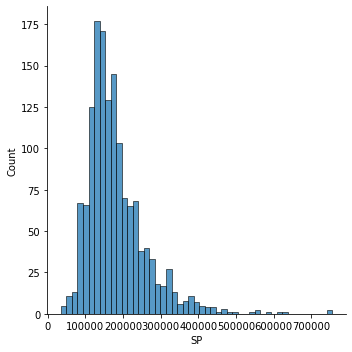

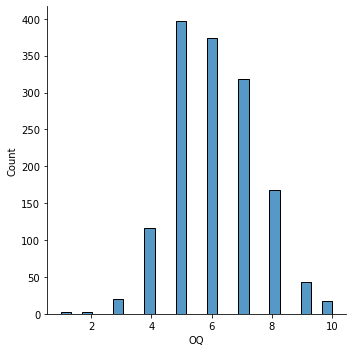

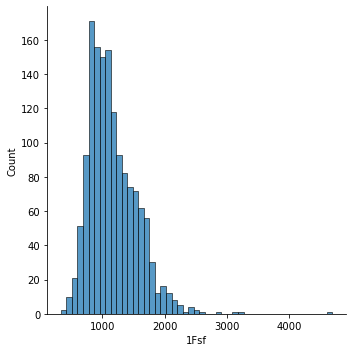

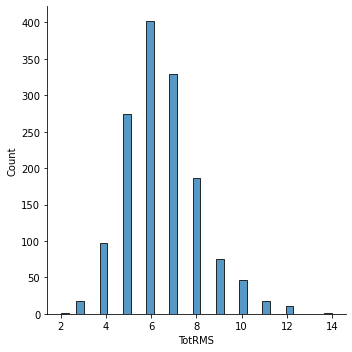

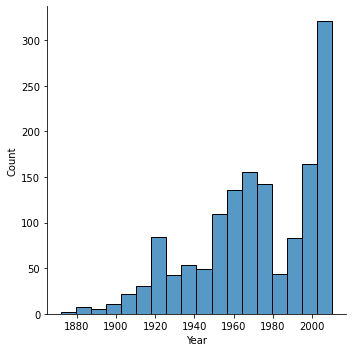

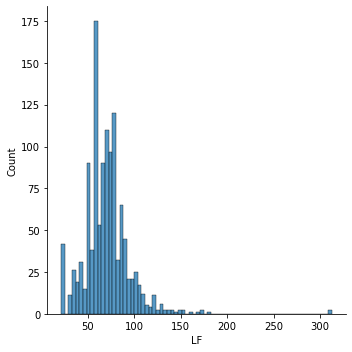

In [15]:
#Grafica de histograma
pFinal.graphHist()

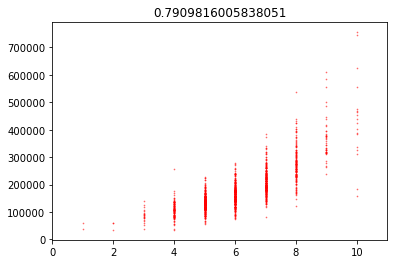

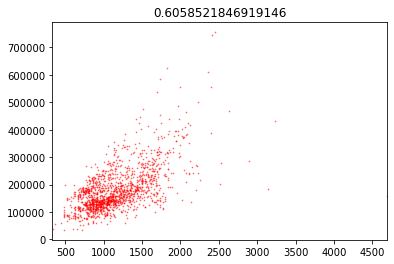

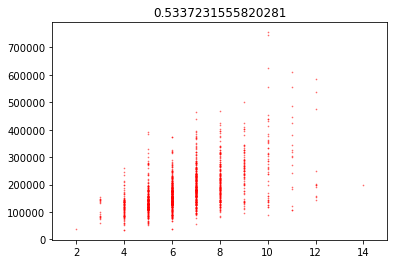

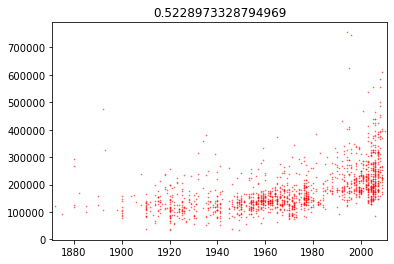

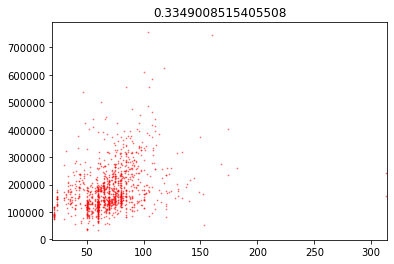

In [16]:
#Calcular coeficientes y grafica de variables independientes vs dependiente
pFinal.r2()
pFinal.plots()

In [24]:
#Entrenar
models, errors = pFinal.entrenar(pFinal.data['1Fsf'], pFinal.data['SP'],10000,1000,0.0000001)

Iteracion 1000:
 37361335099952.766
Iteracion 2000:
 25583151322304.016
Iteracion 3000:
 18280088530504.39
Iteracion 4000:
 13752794242317.463
Iteracion 5000:
 10947228910304.125
Iteracion 6000:
 9209614628941.092
Iteracion 7000:
 8134439682018.17
Iteracion 8000:
 7470181881885.939
Iteracion 9000:
 7060832551873.265
Iteracion 10000:
 6809626206542.423


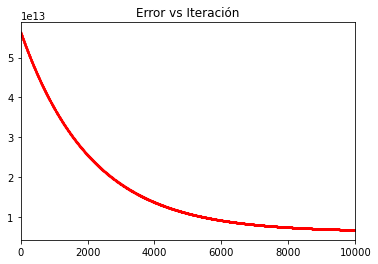

In [25]:
#Graficar error
pFinal.graphError(errors)

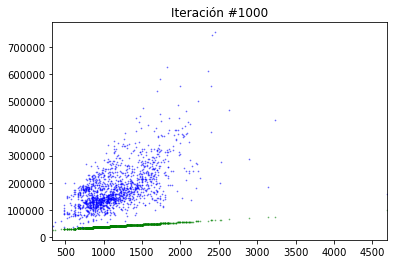

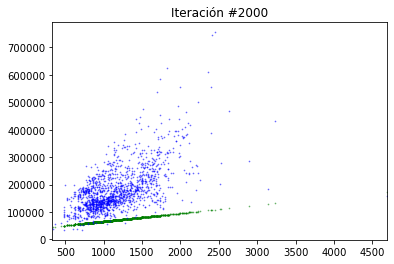

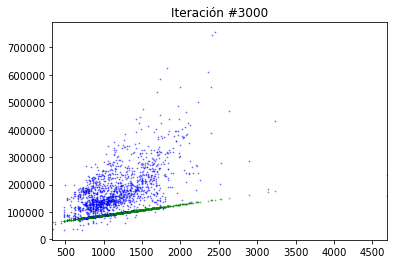

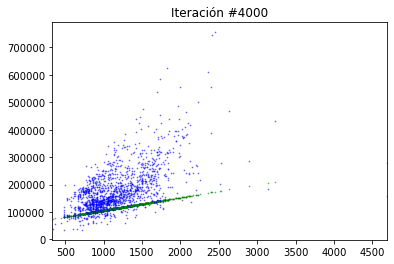

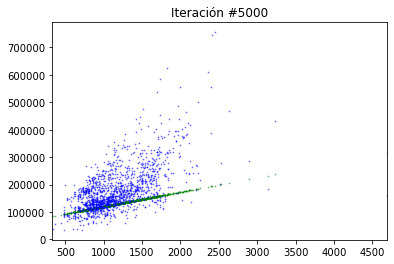

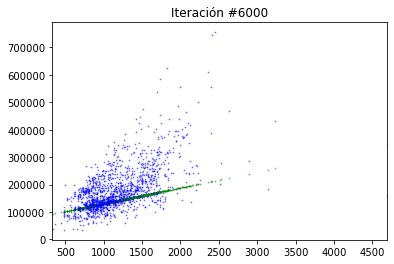

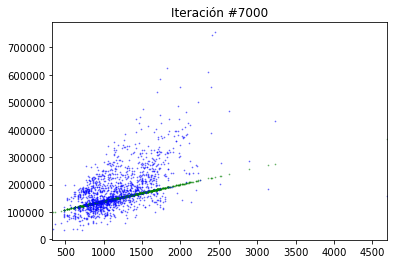

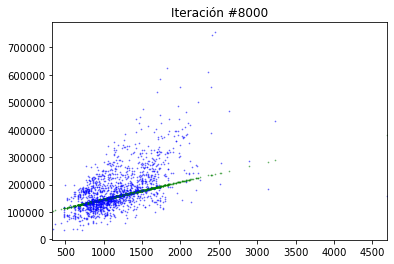

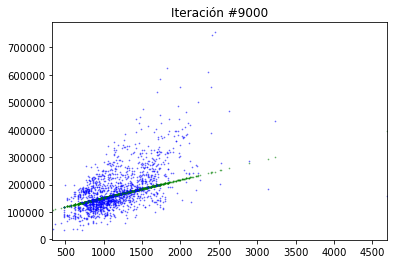

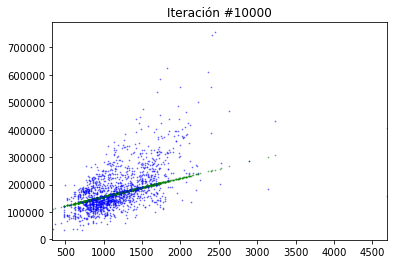

In [27]:
#Graficar modelos
pFinal.graphModels(models, 1000)